In [60]:
import os
import zipfile
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files

In [61]:
# Upload and extract dataset
uploaded = files.upload()
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("animals")

Dataset_dir = "animals/animal_dataset"

Categories = [c for c in os.listdir(Dataset_dir) if os.path.isdir(os.path.join(Dataset_dir, c))]
print("Categories found:", Categories)

Saving animal_dataset.zip to animal_dataset (4).zip
Categories found: ['panda', 'dog', 'cat']


In [62]:
# Load and preprocess images
IMG_SIZE = 32
NUM_IMAGES = 300

all_data = []
for category in Categories:
    path = os.path.join(Dataset_dir, category)
    class_index = Categories.index(category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        all_data.append((img_path, class_index, img_name))

random.shuffle(all_data)
selected_data = all_data[:NUM_IMAGES]

In [63]:
features = []
labels = []
display_data = []

for img_path, class_index, img_name in selected_data:
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        features.append(img.flatten() / 255.0)     # normalize
        labels.append(class_index)
        display_data.append((img, class_index, img_name))
    except:
        continue

features = np.array(features)
labels = np.array(labels)
print("Total images processed:", len(features))

Total images processed: 300


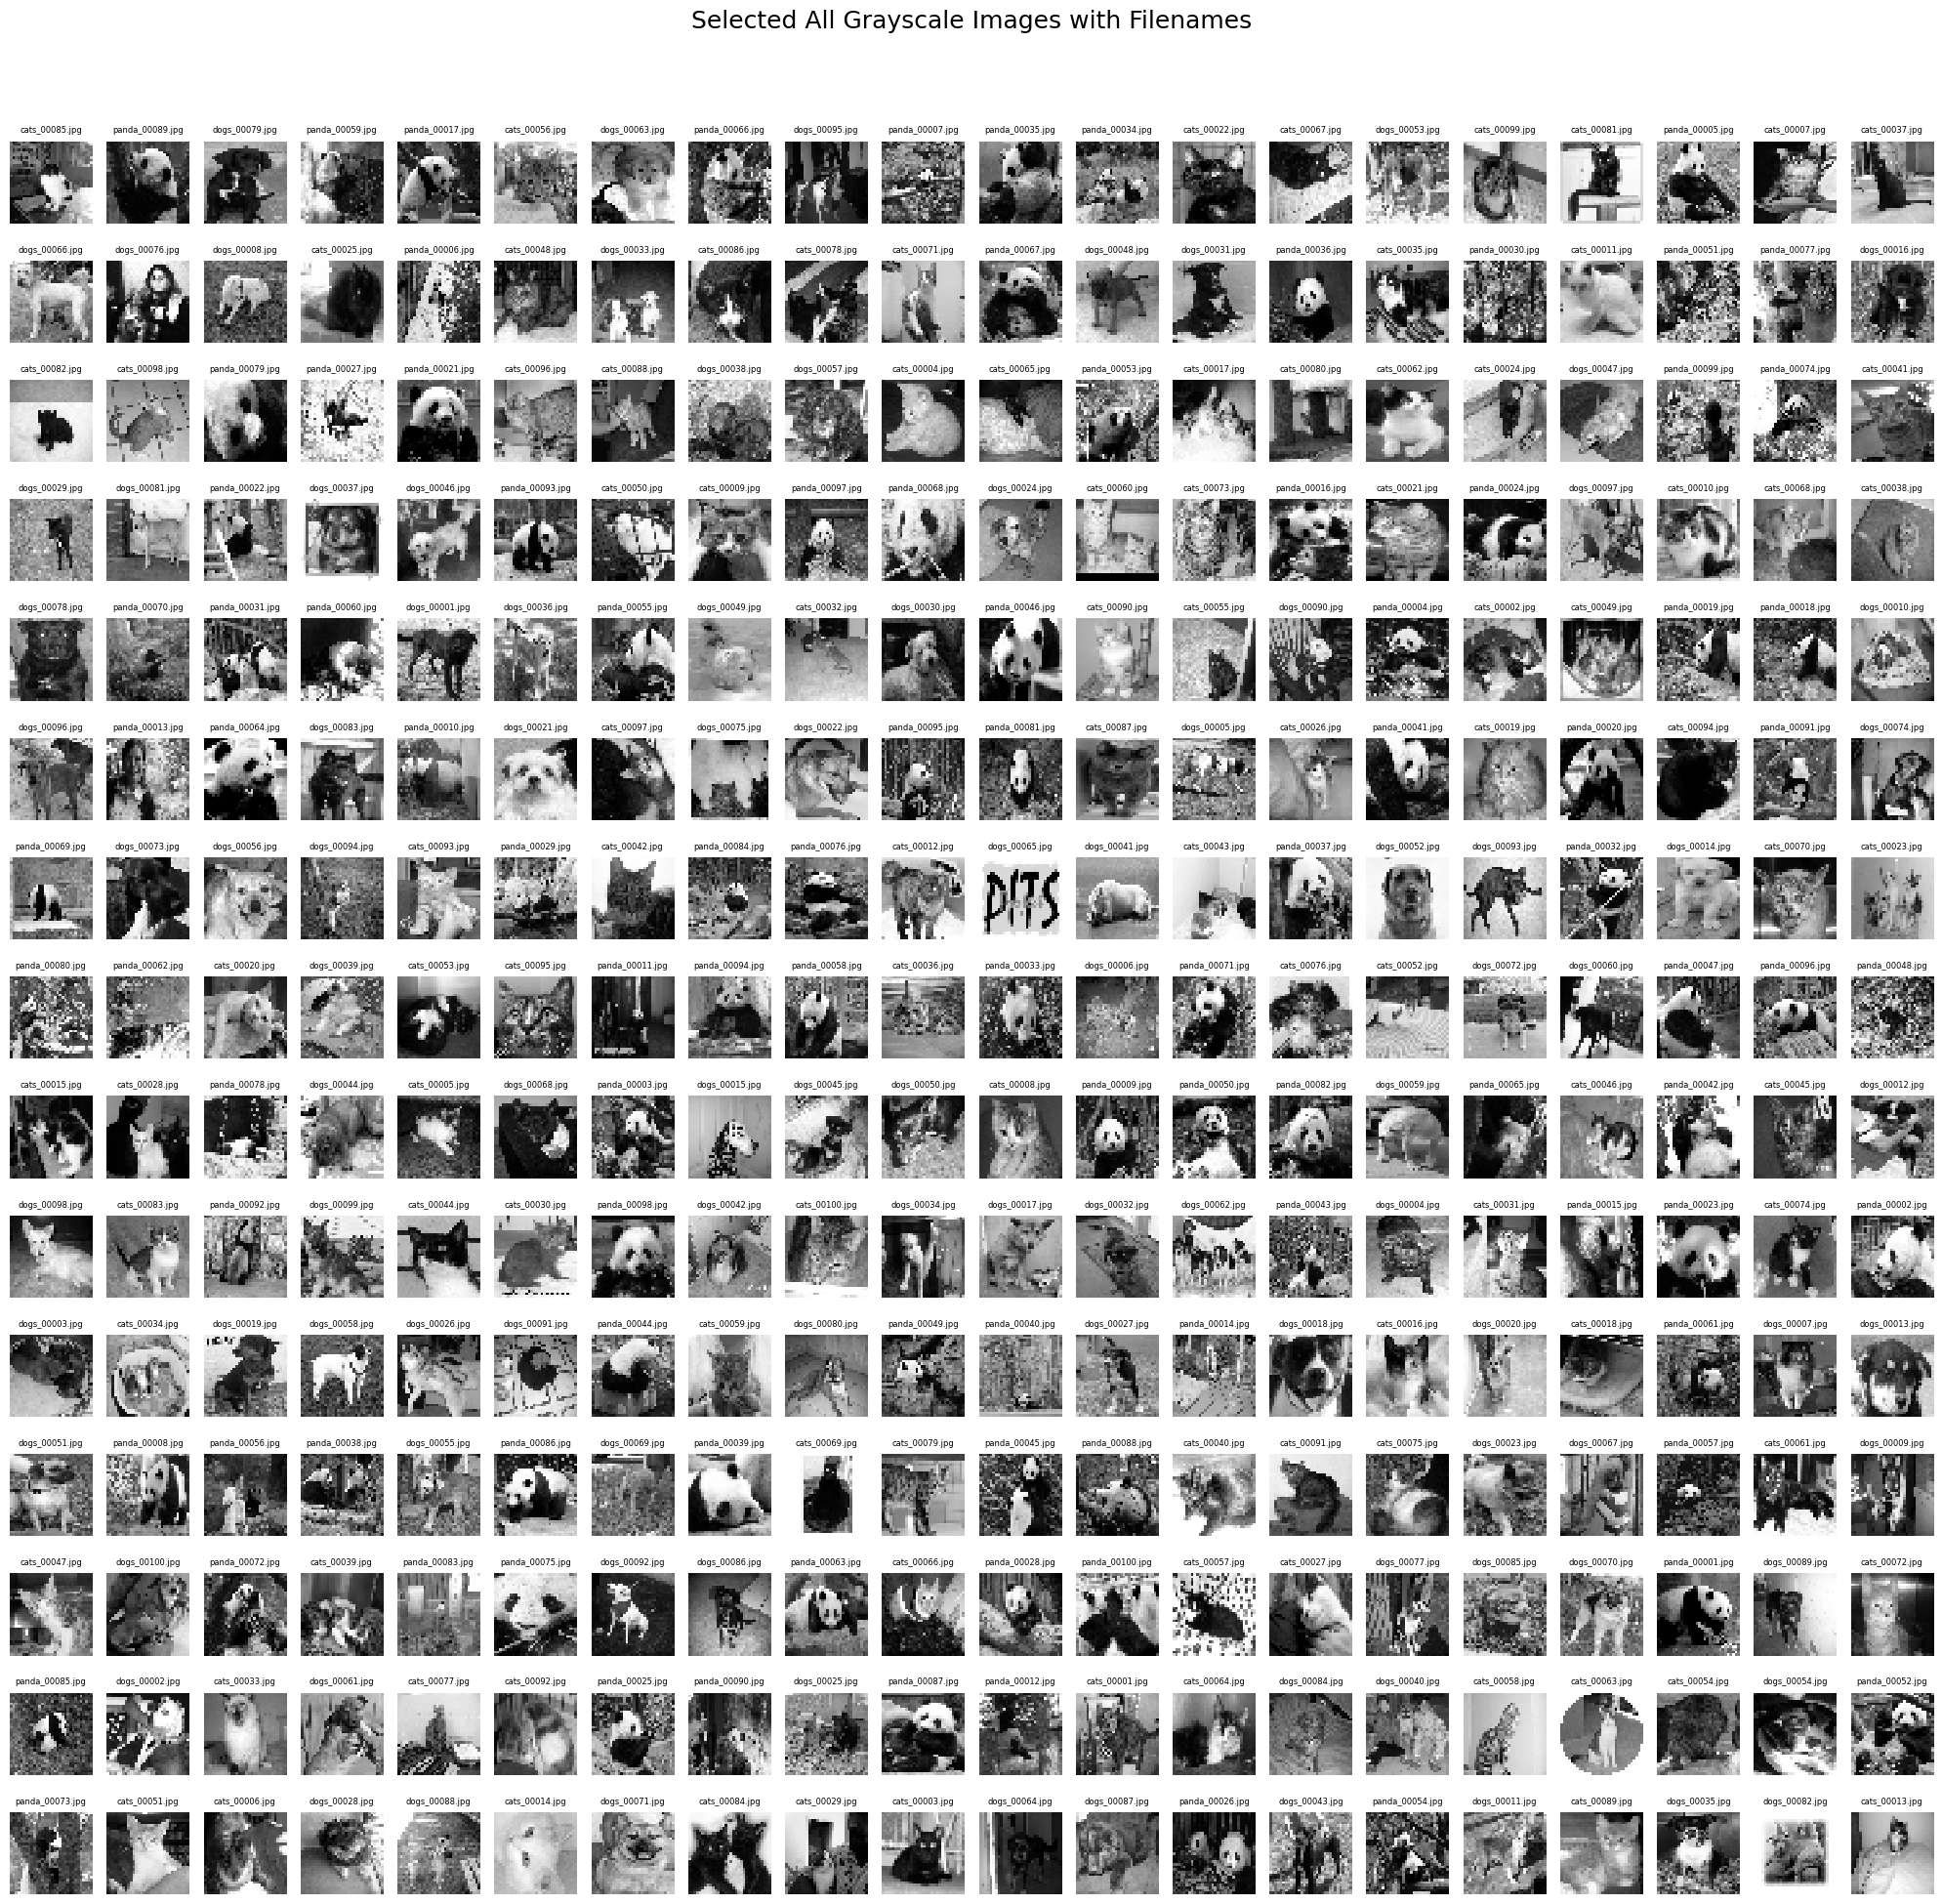

In [64]:
# Display sample images
plt.figure(figsize=(20, 20))
for i in range(min(len(display_data), 300)):
    img, _, name = display_data[i]
    plt.subplot(15, 20, i + 1)
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.title(name[:100], fontsize=6)
    plt.axis('off')

plt.suptitle("Selected All Grayscale Images with Filenames", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()



In [65]:
# Create 5-Fold cross validation
data = list(zip(features, labels))
random.shuffle(data)
fold_size = len(data) // 5
folds = [data[i * fold_size : (i + 1) * fold_size] for i in range(5)]
remainder = len(data) % 5
for i in range(remainder):
    folds[i].append(data[5 * fold_size + i])

for i, fold in enumerate(folds):
    print(f"Fold {i+1} size:", len(fold))

Fold 1 size: 60
Fold 2 size: 60
Fold 3 size: 60
Fold 4 size: 60
Fold 5 size: 60


In [66]:
# Distance functions
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

In [67]:
# kNN prediction
def knn_predict(X_train, y_train, x_test, k=3, distance_type='l2'):
    distances = []
    for i in range(len(X_train)):
        if distance_type == 'l1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]

In [68]:
# Run 5-Fold cross validation
def run_knn_cross_validation(folds, k_values, distance_type='l2'):
    fold_wise_accuracies = []

    for fold_index in range(5):
        validation_data = folds[fold_index]
        training_data = []
        for i in range(5):
            if i != fold_index:
                training_data.extend(folds[i])

        X_train = np.array([item[0] for item in training_data])
        y_train = np.array([item[1] for item in training_data])
        X_val = np.array([item[0] for item in validation_data])
        y_val = np.array([item[1] for item in validation_data])

        fold_accuracies = []
        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            accuracy = (correct / len(X_val)) * 100
            fold_accuracies.append(accuracy)
        fold_wise_accuracies.append(fold_accuracies)

    avg_accuracies = np.mean(fold_wise_accuracies, axis=0)
    return fold_wise_accuracies, avg_accuracies

K_values = np.arange(1, 21)
fold_acc_l1, avg_acc_l1 = run_knn_cross_validation(folds, K_values, distance_type='l1')
fold_acc_l2, avg_acc_l2 = run_knn_cross_validation(folds, K_values, distance_type='l2')

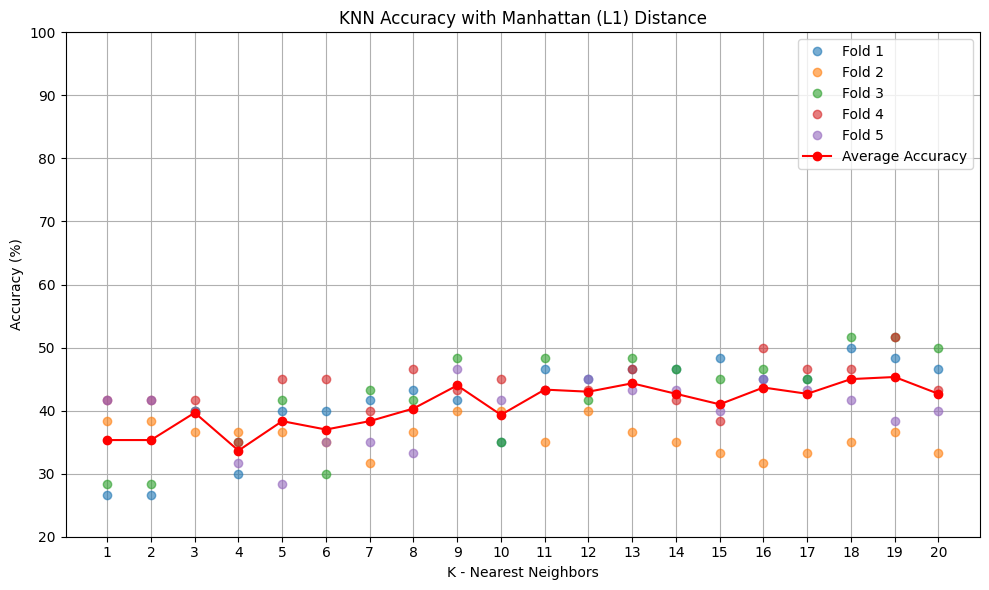

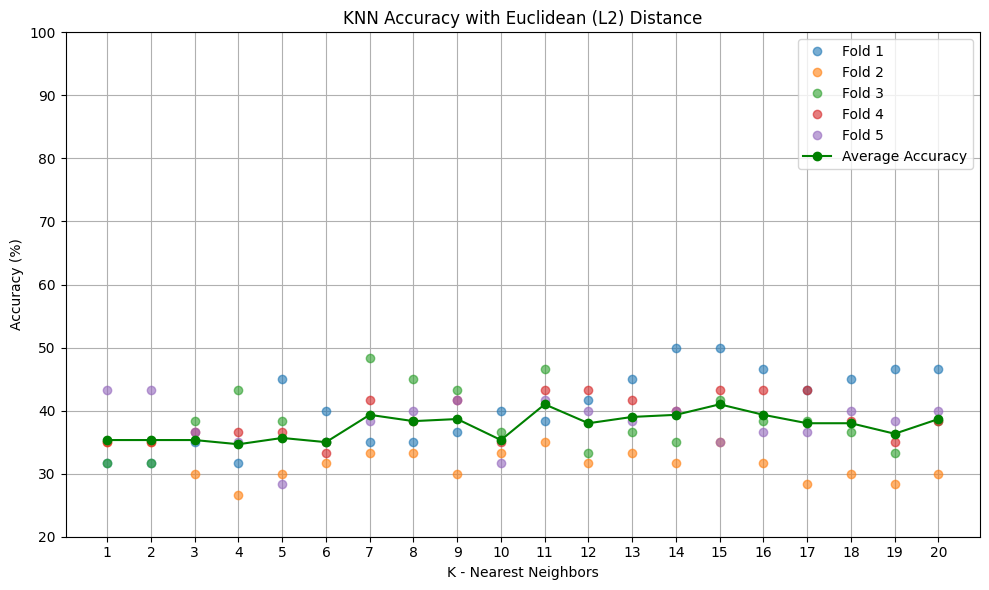

In [69]:
# Plot accuracy
def plot_knn_accuracy(K, fold_accuracies, avg_accuracies, title, color):
    plt.figure(figsize=(10, 6))
    for i, acc in enumerate(fold_accuracies):
        plt.plot(K, acc, 'o', label=f'Fold {i+1}', alpha=0.6)
    plt.plot(K, avg_accuracies, 'o-', color=color, label='Average Accuracy', linewidth=1.5)
    plt.xlabel("K - Nearest Neighbors")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, 21, 1))
    plt.ylim(20, 100)
    plt.tight_layout()
    plt.show()

plot_knn_accuracy(K_values, fold_acc_l1, avg_acc_l1, "KNN Accuracy with Manhattan (L1) Distance", color='red')
plot_knn_accuracy(K_values, fold_acc_l2, avg_acc_l2, "KNN Accuracy with Euclidean (L2) Distance", color='green')

In [70]:
# Print average accuracy
print("Average Accuracy for Manhattan (L1) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l1[i]:.2f}%")

print("\nAverage Accuracy for Euclidean (L2) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l2[i]:.2f}%")

Average Accuracy for Manhattan (L1) Distance:
K =  1 : 35.33%
K =  2 : 35.33%
K =  3 : 39.67%
K =  4 : 33.67%
K =  5 : 38.33%
K =  6 : 37.00%
K =  7 : 38.33%
K =  8 : 40.33%
K =  9 : 44.00%
K = 10 : 39.33%
K = 11 : 43.33%
K = 12 : 43.00%
K = 13 : 44.33%
K = 14 : 42.67%
K = 15 : 41.00%
K = 16 : 43.67%
K = 17 : 42.67%
K = 18 : 45.00%
K = 19 : 45.33%
K = 20 : 42.67%

Average Accuracy for Euclidean (L2) Distance:
K =  1 : 35.33%
K =  2 : 35.33%
K =  3 : 35.33%
K =  4 : 34.67%
K =  5 : 35.67%
K =  6 : 35.00%
K =  7 : 39.33%
K =  8 : 38.33%
K =  9 : 38.67%
K = 10 : 35.33%
K = 11 : 41.00%
K = 12 : 38.00%
K = 13 : 39.00%
K = 14 : 39.33%
K = 15 : 41.00%
K = 16 : 39.33%
K = 17 : 38.00%
K = 18 : 38.00%
K = 19 : 36.33%
K = 20 : 38.67%


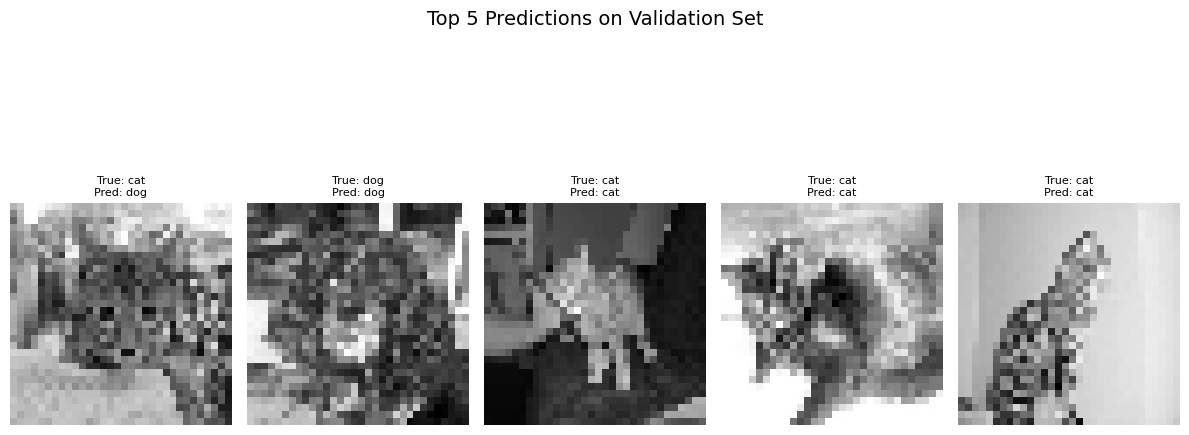

In [71]:
# Display top 5 predictions from validation set (first fold)
top5 = folds[0][:5]
training_set = [item for i, fold in enumerate(folds) if i != 0 for item in fold]

plt.figure(figsize=(12, 6))
for i, (img_flat, true_label) in enumerate(top5):
    pred_label = knn_predict(
        X_train=np.array([item[0] for item in training_set]),
        y_train=np.array([item[1] for item in training_set]),
        x_test=img_flat,
        k=3,
        distance_type='l2'
    )
    img = img_flat.reshape(IMG_SIZE, IMG_SIZE)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {Categories[true_label]}\nPred: {Categories[pred_label]}", fontsize=8)
    plt.axis('off')
plt.suptitle("Top 5 Predictions on Validation Set", fontsize=14)
plt.tight_layout()
plt.show()

**Analysis:**  
In this image classification task with 3 classes and 300 grayscale images, I implemented the k-NN algorithm using both Manhattan (L1) and Euclidean (L2) distance metrics. Using 5-fold cross-validation, I evaluated the model across different values of K (1–20).

The results show that the Manhattan (L1) distance consistently achieved higher average accuracy than the Euclidean (L2) distance. The best performance was observed at K = 19, with an accuracy of 45.33% for L1, while L2 achieved a maximum of 41% at K = 11. This suggests that L1 distance is better suited for this dataset, likely because it is more robust to variations in grayscale pixel values.

The top 5 predictions on test images correctly identified 4 images, further demonstrating that L1 provides more reliable classification for this small, grayscale dataset. Overall, Manhattan (L1) distance is the preferred metric for this task.

**Dataset Characteristics and Their Impact**:

The images, after being downscaled, lose many fine structural details. In such low-resolution images (32×32 or similar), the subtle geometric structure that favors L2 is mostly gone.
L1 becomes more effective because it focuses on absolute differences rather than squared differences.
Additionally, variations in lighting, shadows, and background affect L2 more strongly, while L1 remains more stable.

**Limitations**:

Pixel-level comparison without normalization makes both distances sensitive to brightness changes, but L2 suffers more due to squared error effects.
No preprocessing such as smoothing, histogram equalization, or noise reduction was applied, which may have favored the robustness of L1.
Downscaling reduces fine details, making L2 less effective at capturing class-specific geometric differences.
k-NN’s computational cost remains high because each new sample requires distance calculation with all training samples.
